Import Dependencies

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold,learning_curve
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt
import time

Load  data into a  DataFrame

In [36]:
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')
mb_data_frame = pd.DataFrame(mb_raw_data)
# Delete all columns except Sequence, m/z, and CCS
mb_clean_frame = mb_data_frame[['Sequence', 'm/z', 'CCS']]
# Log transform CCS values
mb_clean_frame['CCS_ln'] = mb_clean_frame['CCS'].apply(lambda x: np.log(x))

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_14808\4215409237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_ln'] = mb_clean_frame['CCS'].apply(lambda x: np.log(x))


Train Model

In [37]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[['m/z']]
y = mb_clean_frame['CCS_ln']
# Define the number of folds
k = 4
# Number of trees
n = 10

Perform k-fold cross validation

In [38]:
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)

# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a random forest regressor model
    model = LinearRegression(n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred - y_test) / y_test)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X, y)
# Print all mse scores
#print("All Mean Squared Errors:", mse_scores)
# Average the MSE scores
average_mse = np.mean(mse_scores)
# Print the average MSE score
print("Average Mean Squared Error:", average_mse)
# Print the median of the relative errors for each fold
#print("Median Relative Errors:", median_relative_errors)
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the R^2 scores for each fold
#print("R^2 Scores:", r2_score)
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')
print(str(n) + "\t" + str(average_mse) + "\t" + str(np.mean(median_relative_errors)) + "\t" + str(np.mean(r2_scores)) + "\t" + str(elapsed_time))

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.2570801913800499
Average Median Relative Error: 0.004572234633760278
Average R^2 Score: 0.14476212828333812
Time elapsed: 0.48 seconds
10	0.2570801913800499	0.004572234633760278	0.14476212828333812	0.47641444206237793


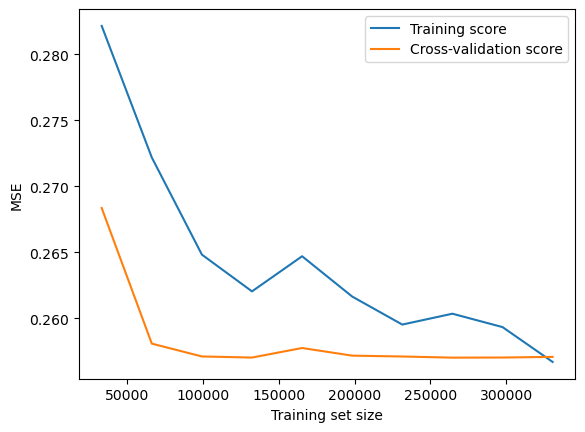

In [39]:
from sklearn.model_selection import learning_curve

# Define the sizes of the training sets to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(n_jobs=-1),
    X,
    y,
    train_sizes=train_sizes,
    cv=k,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate the average training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [40]:
# Input the m/z value of the peptide you want to predict the CCS of
mz = 1074.04135
# Predict the CCS of the peptide
ccs = final_model.predict([[mz]])
# Reverse the log transformation
ccs = np.exp(ccs)
print("Predicted CCS:", ccs)

Predicted CCS: [1.0213476e-35]


C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Save the model

In [41]:
# Add a column to the data frame with the length of each peptide sequence
mb_clean_frame['Sequence Length'] = mb_clean_frame['Sequence'].apply(lambda x: len(x))
# Predict the CCS of the peptides in the data frame
mb_clean_frame['Predicted CCS'] = final_model.predict(mb_clean_frame[['m/z']])
# Reverse the log transformation
mb_clean_frame['Predicted CCS'] = np.exp(mb_clean_frame['Predicted CCS'])

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_14808\1414671599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Sequence Length'] = mb_clean_frame['Sequence'].apply(lambda x: len(x))
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_14808\1414671599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Predicted CCS'] = final_model.predict(mb_clean_frame[['m/z']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_14808\1414671599.py:6: SettingWithCopyWarning: 
A va

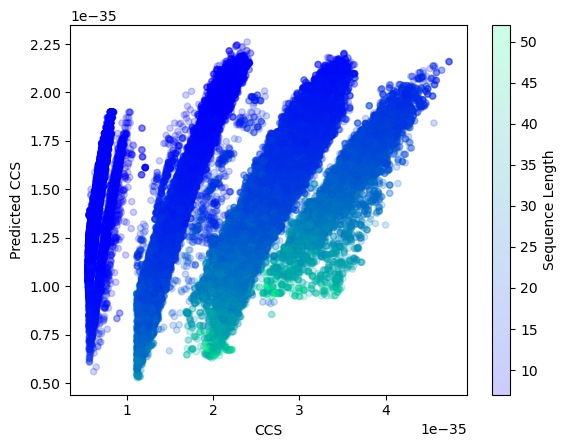

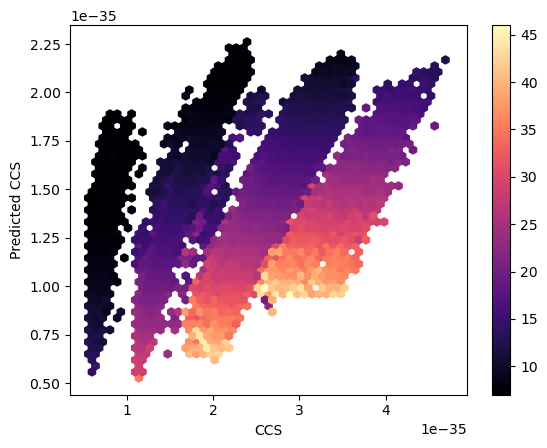

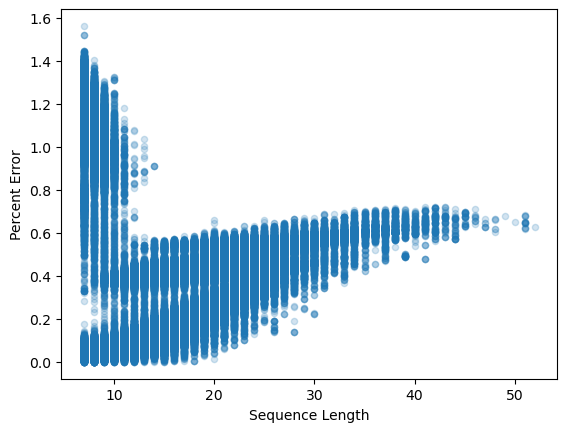

Spearman's Correlation Coefficient: 0.5785497863049393


C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_14808\1715360094.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
C:\ProgramData\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Sequence Length', ylabel='Percent Error'>

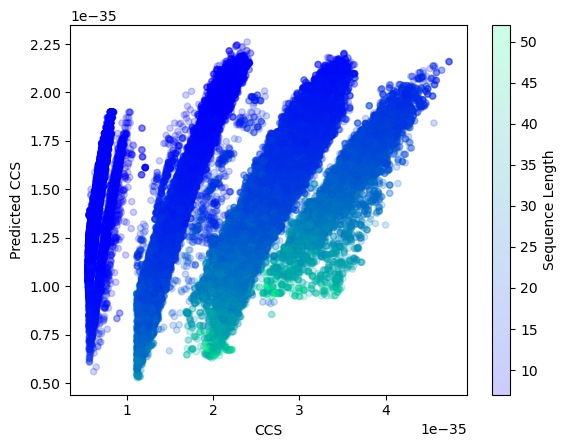

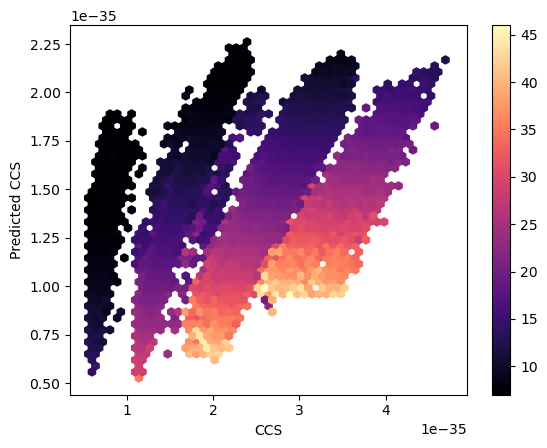

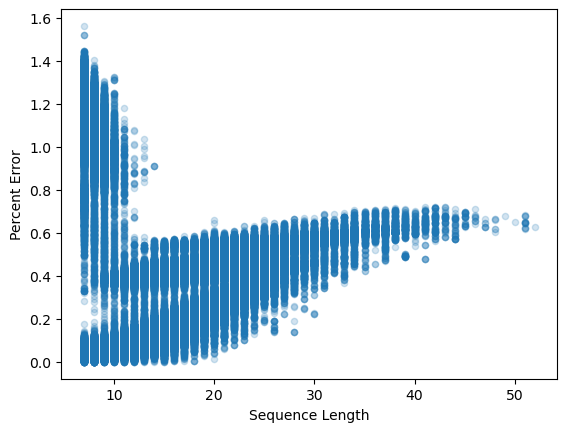

In [42]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Sequence Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Sequence Length'].min(),
    vmax=mb_clean_frame['Sequence Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Sequence Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
#Now we want to create a plot with percent error between CCS and Predictes CCS and graph that by sequence length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Sequence Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Sequence Length'].min(),
    vmax=mb_clean_frame['Sequence Length'].max()
)

Save the model to a file

In [43]:
filename = '../../models/lin_reg/lin_reg.pkl'
pickle.dump(model, open(filename, 'wb'))